In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
%matplotlib inline

In [322]:
#read in data (90,348 rows not inclusive of header)
df_og = pd.read_csv("data/Aviation_Data.csv")
df = df_og.copy()

print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

/var/folders/zp/y3_8cd0s1tz68ksgv9pnl2ch0000gn/T/ipykernel_3456/1295400394.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_og = pd.read_csv("data/Aviation_Data.csv")


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


# Preliminary Formatting Change and Filtering

In [324]:
# Replaces "." with "_" in column names for ease of copy, paste
df.columns = df.columns.str.replace('.', "_")

# Extracting year from Event Date to assess how data changes by year
df['Year'] = [str(year).split('-')[0] for year in df['Event_Date']]

# Filtering dataframe to only show entries in Aircraft_Category that are Airplane. Reducing to 27,617 rows.
df = df.loc[df['Aircraft_Category'] == 'Airplane']

# The company will utilize professionally built planes. To best understand risk associated wiht professionally
# built planes, amateur-built will be removed from the dataset. Reducing to 24,417 rows.
df = df.loc[df['Amateur_Built'] == 'No']

# Filtering dataframe to only show entries that have a Year 2000 as there were stricter air regulations enforced after 9/11
# and it makes sense to only show data around 20 years back from our problem. Reducing to 21,150 rows.
df = df.loc[df['Year'].astype(int) > 2000]

#Filtering out entries from Purpose_of_flight that arent one of 7 categories(Personal, Business, Executive/Corporate,
#Public Aircraft - Federal, Public Aircraft - State, Public Aircraft - Local or Public Aircraft)
#This is because we are looking to find an aircraft specifically for commercial and private activities. Reducing to 12,380 rows.
df = df.loc[df['Purpose_of_flight'].isin(['Personal','Business', 'Executive/corporate', 'Public Aircraft - Federal', 
                                          'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft'])]

# Same Makes showing up as different because of capitalization. Changing all Makes and Model to Title case
df['Make'] = [make.title() for make in df['Make']]

# Unifying name for several Manufacturers with mulitple names.
df_dict_name = {'Aviat' : 'Aviat Aircraft Inc', 'Cirrus' : 'Cirrus Design Corp' , 'Cirrus Design Corp.' : 'Cirrus Design Corp', 'Gulfstream' : 'Gulfstream Aerospace', 'Learjet' : 'Learjet Inc', 'Raytheon' : 'Raytheon Aircraft Company'} 
df['Make'] = df['Make'].replace(df_dict_name)

# Dropping of investigations where US Location is "Unknown,"
df = df.drop(df[(df['Country'] == 'United States') & (df['Location'] == 'Unknown,')].index)
df = df.drop(df[(df['Country'] == 'United States') & (df['Location'] == ',')].index)

# Cleaning of US Locations to ensure all include abbreviations, where o, = Gulf of Mex, g, = Tamuning, GUAM (GU), e, = Charlotte Amalie, VI, PO = Pacific Ocean, VI = Virgin Islands, d, = Christiansted, VI,
#x, = St. Croix, VI, a, = Santa Rita, NM, O, = Gulf of Mexico, GM

df_dict_abbrev = {'Gulf of Mexico,' : 'Gulf of Mexico, GM', 'Tamuning,' : 'Tamuning, GU' , 'Charlotte Amalie,' : 'Charlotte Amalie, VI', 'Christiansted,' : 'Christiansted, VI', 'St. Croix,' : 'St. Croix, VI', 'Santa Rita,' : 'Santa Rita, NM', 'GULF OF MEXICO,' : 'Gulf of Mexico, GM'} 
df['Location'] = df['Location'].replace(df_dict_abbrev)

# Grabbing state abbreviations from Locations column
df['State'] = df.apply(lambda row: row['Location'][-2:] if row['Country'] == 'United States' else None, axis = 1)

# Mapping states to four regions: Northwest, Northeast, Southwest, Southeast
state_map = {'NW' : ['AK', 'ID', 'MT', 'ND', 'NE', 'OR', 'SD', 'WA', 'WY'], 'NE' : ['CT', 'DE', 'IA', 'IL', 'IN', 'KY', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NH', 'NJ', 'NY', 'OH', 'PA', 'RI', 'VA', 'VT', 'WI', 'WV'], 
                 'SW' : ['AZ', 'CA', 'CO', 'HI', 'KS', 'NM', 'NV', 'OK', 'PO', 'TX', 'UT'], 'SE' : ['AL', 'AR', 'FL', 'GA', 'GM', 'GU', 'LA', 'MS', 'NC', 'AO', 'PR', 'SC', 'TN', 'VI']}
df['Region'] = df['State'].map({v: k for k, values in state_map.items() for v in values})

# For Weather Condition, unknown is represented by "Unk" and "UNK". Converting them both to "Unknown".
df = df.replace(('Unk', 'UNK'), 'Unknown')

# Replacing NaN with 0 for all injury data
df["Total_Fatal_Injuries"].fillna(0, inplace=True)
df["Total_Serious_Injuries"].fillna(0, inplace=True)
df["Total_Minor_Injuries"].fillna(0, inplace=True)
df["Total_Uninjured"].fillna(0, inplace=True)


print(df.info(), '\n \n')

<class 'pandas.core.frame.DataFrame'>
Index: 12375 entries, 49949 to 90345
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                12375 non-null  object 
 1   Investigation_Type      12375 non-null  object 
 2   Accident_Number         12375 non-null  object 
 3   Event_Date              12375 non-null  object 
 4   Location                12374 non-null  object 
 5   Country                 12375 non-null  object 
 6   Latitude                12260 non-null  object 
 7   Longitude               12255 non-null  object 
 8   Airport_Code            8930 non-null   object 
 9   Airport_Name            8974 non-null   object 
 10  Injury_Severity         12360 non-null  object 
 11  Aircraft_damage         12313 non-null  object 
 12  Aircraft_Category       12375 non-null  object 
 13  Registration_Number     12343 non-null  object 
 14  Make                    12375 non-null 

/var/folders/zp/y3_8cd0s1tz68ksgv9pnl2ch0000gn/T/ipykernel_3456/3295562614.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Total_Fatal_Injuries"].fillna(0, inplace=True)
/var/folders/zp/y3_8cd0s1tz68ksgv9pnl2ch0000gn/T/ipykernel_3456/3295562614.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

## Exploratory Data Analysis

In [326]:
#Create a Value Count for each column
for i in range(len(df.columns)):
    print(df.iloc[:, i].value_counts(), '\n', '\n', '----------------------------------------\n')

Event_Id
20030625X00951    2
20220111104514    2
20220808105682    2
20220608105217    2
20220818105763    2
                 ..
20101026X44534    1
20101023X35000    1
20101025X33022    1
20101023X94911    1
20221227106497    1
Name: count, Length: 12367, dtype: int64 
 
 ----------------------------------------

Investigation_Type
Accident    12259
Incident      116
Name: count, dtype: int64 
 
 ----------------------------------------

Accident_Number
ERA22LA103    2
ERA22LA364    2
WPR22LA201    2
WPR22FA309    2
ERA22LA379    2
             ..
ERA11LA033    1
WPR11FA021    1
CEN11FA040    1
WPR11CA024    1
WPR23LA075    1
Name: count, Length: 12368, dtype: int64 
 
 ----------------------------------------

Event_Date
2022-07-15    10
2008-06-29    10
2008-08-02    10
2007-10-07    10
2011-07-23    10
              ..
2012-12-16     1
2012-12-17     1
2012-12-18     1
2012-12-20     1
2022-12-26     1
Name: count, Length: 5445, dtype: int64 
 
 ------------------------------------

In [327]:
inv_years = df['Year']
inv_years_dist = inv_years.value_counts().sort_index()
inv_years_dist

Year
2001     23
2002     38
2003    100
2004    284
2005    400
2006    416
2007    555
2008    814
2009    789
2010    822
2011    794
2012    782
2013    673
2014    644
2015    684
2016    695
2017    665
2018    657
2019    651
2020    595
2021    640
2022    654
Name: count, dtype: int64

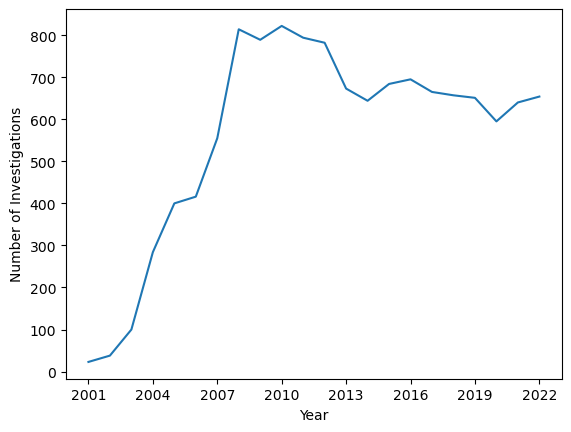

In [328]:
fig, ax = plt.subplots()

ax.plot(inv_years_dist.index, inv_years_dist.values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel('Number of Investigations')
ax.set_xlabel("Year")
plt.show()

##  Quantifying impact to human safety and airplane damage

In [330]:
#Calculating the total number of passengers (assuming) = killed + injured + not-injured and per cent of passengers
#killed or injured. Total Passengers = 0 for 25 entries.

df['Total_Passengers'] = df['Total_Fatal_Injuries'] + df['Total_Serious_Injuries'] + df['Total_Minor_Injuries'] + df['Total_Uninjured']

df['Fatality_pct'] = df['Total_Fatal_Injuries'] / df['Total_Passengers'] * 100

df['Injured_pct'] = (df['Total_Serious_Injuries'] + df['Total_Minor_Injuries']) / df['Total_Passengers'] * 100

In [331]:
#Assuming Aircraft_damage = NaN or Unknown = No damage. Created new feature 'Airplane_Damage' to capture these
#definitions.

ad_dict = {'Destroyed' : 'Destroyed', 'Substantial' : 'Substantial', 'Minor' : 'Minor', 'Unknown' : 'No damage', np.nan : 'No damage'}
df['Airplane_Damage'] = df['Aircraft_damage'].map(ad_dict)

In [332]:
# Making Airplane_Damage quantitative
ad_dict_quant = {'Destroyed' : 3, 'Substantial' : 2, 'Minor' : 1, 'No damage' : 0}
df['Airplane_Damage_quant'] = df['Airplane_Damage'].map(ad_dict_quant)

In [333]:
df['Make'].value_counts().sort_values(ascending = False)[:20]

Make
Cessna                         4346
Piper                          2718
Beech                          1024
Mooney                          310
Cirrus Design Corp              276
Maule                           196
Bellanca                        179
Aeronca                         163
Champion                        131
Aviat Aircraft Inc              129
Luscombe                        126
Stinson                         117
Boeing                           97
North American                   84
Taylorcraft                      78
Socata                           58
Raytheon Aircraft Company        56
Ercoupe                          45
Grumman American Avn. Corp.      43
Aero Commander                   41
Name: count, dtype: int64

In [334]:
# Looking at Airbus
df.loc[df['Make'] == 'Airbus']['Model'].value_counts()

Model
A330    1
Name: count, dtype: int64

In [335]:
# Looking at Embraer
df.loc[df['Make'] == 'Embraer']['Model'].value_counts()

Model
EMB-500     3
EMB711      2
500         1
810D        1
711ST       1
EMB 720C    1
EMB-505     1
EMB-710C    1
EMB721C     1
EMB720      1
EMB820      1
EMB500      1
Name: count, dtype: int64

In [336]:
# Looking at Bombardier
df.loc[df['Make'] == 'Bombardier']['Model'].value_counts()

Model
CL-600-2B16    1
BD100 1A10     1
Name: count, dtype: int64

In [337]:
# Seperating flights by Commercial vs Private
df_com = df.loc[df['Purpose_of_flight'].isin(['Personal', 'Public Aircraft - Federal', 
                                          'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft'])]
df_pri = df.loc[df['Purpose_of_flight'].isin(['Business', 'Executive/corporate'])]

In [338]:
df_com = df_com.loc[df_com['Make'].isin(list(df_com['Make'].value_counts()[:20].index))]
df_com = df_com.loc[(df_com['Fatality_pct'] > 0) & (df_com['Injured_pct'] > 0)]

df_com['Make'].value_counts()

Make
Cessna                         76
Piper                          68
Beech                          38
Mooney                         13
Cirrus Design Corp             11
Maule                           8
North American                  5
Bellanca                        4
Aeronca                         4
Luscombe                        3
Boeing                          3
Socata                          3
Taylorcraft                     2
Stinson                         2
American Champion Aircraft      1
Grumman American Avn. Corp.     1
Aviat Aircraft Inc              1
Name: count, dtype: int64

In [339]:
df_pri = df_pri.loc[df_pri['Make'].isin(list(df_pri['Make'].sort_values(ascending = False).value_counts()[:20].index))]
df_pri = df_pri.loc[(df_pri['Fatality_pct'] > 0) & (df_pri['Injured_pct'] > 0)]

df_pri['Make'].value_counts()

Make
Cessna                       5
Piper                        4
Cirrus Design Corp           2
Beech                        2
Socata                       2
Raytheon Aircraft Company    1
Name: count, dtype: int64

In [340]:
df['Region'].value_counts()

Region
SW    3900
NE    3287
NW    2451
SE    2406
Name: count, dtype: int64

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12375 entries, 49949 to 90345
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                12375 non-null  object 
 1   Investigation_Type      12375 non-null  object 
 2   Accident_Number         12375 non-null  object 
 3   Event_Date              12375 non-null  object 
 4   Location                12374 non-null  object 
 5   Country                 12375 non-null  object 
 6   Latitude                12260 non-null  object 
 7   Longitude               12255 non-null  object 
 8   Airport_Code            8930 non-null   object 
 9   Airport_Name            8974 non-null   object 
 10  Injury_Severity         12360 non-null  object 
 11  Aircraft_damage         12313 non-null  object 
 12  Aircraft_Category       12375 non-null  object 
 13  Registration_Number     12343 non-null  object 
 14  Make                    12375 non-null 

## Write to File

In [343]:
#exporting data to file for private and commercial datasets
#df_com.to_csv("data/Output_Data_commercial.csv")
#df_pri.to_csv("data/Output_Data_private.csv")

## Appendix

### Assessment of Investigation Type over Time

In [346]:
inv_years_acc = df.loc[df['Investigation_Type'] == 'Accident']['Year']
inv_years_dist_acc = inv_years_acc.value_counts().sort_index()

df_inv_type_acc = pd.DataFrame(inv_years_dist_acc).reset_index()
df_inv_type_acc.columns = ['Year', 'Accidents']

inv_years_inc = df.loc[df['Investigation_Type'] == 'Incident']['Year']
inv_years_dist_inc = inv_years_inc.value_counts().sort_index()

df_inv_type_inc = pd.DataFrame(inv_years_dist_inc).reset_index()
df_inv_type_inc.columns = ['Year', 'Incidents']

df_inv_type_merge = pd.merge(df_inv_type_acc, df_inv_type_inc, how = 'outer', on = 'Year')
df_inv_type_merge['Incidents'] = df_inv_type_merge['Incidents'].fillna(0)

df_inv_type_merge['Accidents_pct'] = df_inv_type_merge['Accidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100
df_inv_type_merge['Incidents_pct'] = df_inv_type_merge['Incidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100

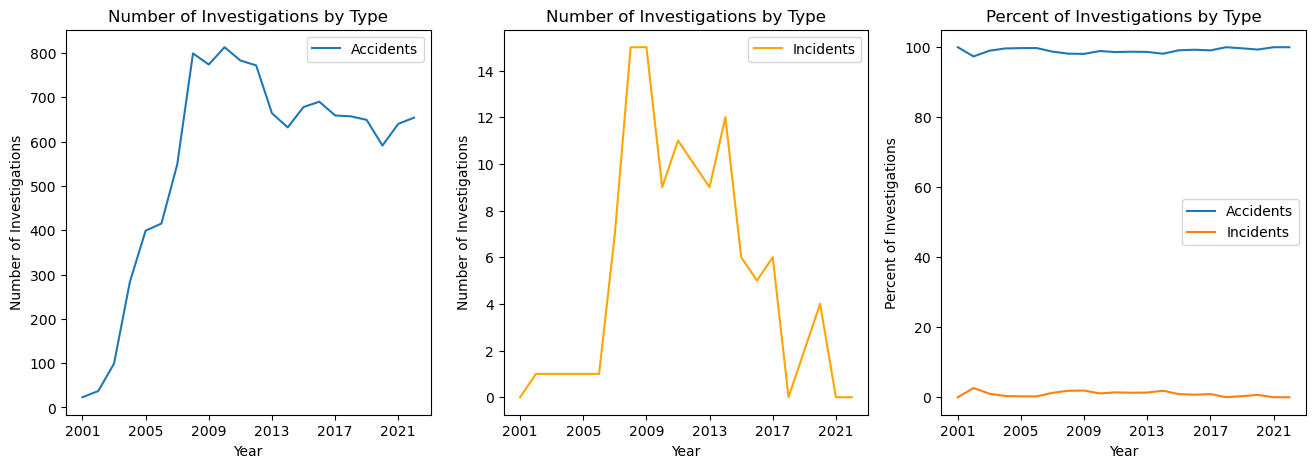

In [347]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (16, 5))

ax1.plot(df_inv_type_merge['Year'], df_inv_type_merge['Accidents'], label = 'Accidents')

ax2.plot(df_inv_type_merge['Year'], df_inv_type_merge['Incidents'], label = 'Incidents', color='orange')

ax3.plot(df_inv_type_merge['Year'], df_inv_type_merge['Accidents_pct'], label = 'Accidents')
ax3.plot(df_inv_type_merge['Year'], df_inv_type_merge['Incidents_pct'], label = 'Incidents')

ax1.legend()
ax2.legend()
ax3.legend()

ax1.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(4))

ax1.set_title('Number of Investigations by Type')
ax1.set_ylabel('Number of Investigations')
ax1.set_xlabel("Year")

ax2.set_title('Number of Investigations by Type')
ax2.set_ylabel('Number of Investigations')
ax2.set_xlabel("Year")

ax3.set_title('Percent of Investigations by Type')
ax3.set_ylabel('Percent of Investigations')
ax3.set_xlabel("Year")

plt.show()